# Do station analyses for coupled and uncoupled simulations

In [2]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
import cartopy.io.img_tiles as cimgt
import cmocean.cm as cmo
import xroms
import xesmf as xe
import skill_metrics as sm
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import NearestNDInterpolator

import datetime
from glob import glob
import os
import time
import calendar

In [6]:
stn_lon = [-118.6411, -123.465, -117.471283, -119.89175, -120.779817,
            -120.859314, -118.316833, -124.72805, -117.39, -118.578333,
            -122.6315, -117.27945, -117.16895, -122.103889, -121.9071,
            -124.357, -117.4252, -117.26667, -119.563, -118.182033, -118.200668,
            -117.501683, -121.49661, -117.314075, -117.500133, -121.8247,
            -121.8202, -117.658611, -122.33, -122.0333333
          ]

In [7]:
stn_lat = [33.859933, 37.940322, 33.179416, 33.2251, 34.45165,
           35.203815, 33.617933, 40.291217, 32.93, 34.022222,
           37.7881, 32.956583, 32.56968, 36.334777, 36.6263,
           40.89603, 32.5167, 32.86785, 33.7685, 33.577667,
           33.700333, 32.749417, 34.76667, 33.062078, 33.28995,
           36.8449, 36.838, 33.336389, 36.68666667, 36.935
]


In [8]:
# All CDIP station names

stn_name = ['SANTA MONICA BAY, CA',
            'POINT REYES, CA',
            'OCEANSIDE OFFSHORE, CA',
            'SAN NICOLAS ISLAND, CA',
            'HARVEST, CA',
            'DIABLO CANYON, CA',
            'SAN PEDRO, CA',
            'CAPE MENDOCINO, CA',
            'TORREY PINES OUTER, CA',
            'TOPANGA NEARSHORE, CA',
            'SAN FRANCISCO BAR, CA',
            'DEL MAR NEARSHORE, CA',
            'IMPERIAL BEACH NEARSHORE, CA',
            'POINT SUR, CA',
            'CABRILLO POINT NEARSHORE, CA',
            'HUMBOLDT BAY NORTH SPIT, CA',
            'POINT LOMA SOUTH, CA',
            'SCRIPPS NEARSHORE, CA',
            'SANTA CRUZ BASIN, CA',
            'SAN PEDRO SOUTH, CA',
            'LONG BEACH CHANNEL, CA',
            'MISSION BAY WEST, CA',
            'SANTA LUCIA ESCARPMENT, CA',
            'LEUCADIA NEARSHORE, CA',
            'RED BEACH NEARSHORE, CA',
            'PAJARO BEACH, CA',
            'PAJARO BEACH SOUTH, CA',
            'GREEN BEACH OFFSHORE, CA',
            'MONTEREY BAY WEST, CA',
            'POINT SANTA CRUZ, CA'
           ]

In [9]:
# Do full year analysis
calmons = list(calendar.month_abbr)

plotmons = calmons[7::] + calmons[1:5]
for i in range(len(plotmons)):
    if i<=5:
        plotmons[i] = plotmons[i]+'21'
    else:
        plotmons[i] = plotmons[i]+'22'

plotmons

['Jul21',
 'Aug21',
 'Sep21',
 'Oct21',
 'Nov21',
 'Dec21',
 'Jan22',
 'Feb22',
 'Mar22',
 'Apr22']

In [10]:
# Load all observed CDIP data

all_21 = []
all_22 = []

for i in range(12):
    month_ID = i + 1
    stn_fid = 'Station_Data/cdip_buoys/cdip.buoy.*.c1.2021' + f"{month_ID:02}" + '*.nc'
    all_21.append(sorted(glob(stn_fid)))
    stn_fid = 'Station_Data/cdip_buoys/cdip.buoy.*.c1.2022' + f"{month_ID:02}" + '*.nc'
    all_22.append(sorted(glob(stn_fid)))

In [15]:
# Read in ROMS station files
sfiles = glob('Station_Data/roms_station_data/roms_202*_ocean_sta.nc')
sfiles.sort()

# Open ROMS station datasets

solo_dss = []

for srfile in sfiles:
    ids = xr.open_dataset(srfile)
    ids = ids.isel(ocean_time=slice(0,-1))
    solo_dss.append(ids)

solo_rstn_ds = xr.concat(solo_dss, dim="ocean_time")

In [23]:
# Read in ROMS station files
csfiles = glob('Station_Data/coawst_station_data/coawst_202*_ocean_sta.nc')
csfiles.sort()

cpd_dss = []

for csrfile in cs_files:
    ids = xr.open_dataset(csrfile)
    ids = ids.isel(ocean_time=slice(0,-1))
    cpd_dss.append(ids)

cpd_rstn_ds = xr.concat(cpd_dss, dim="ocean_time")

In [24]:
cpd_avg = cpd_rstn_ds.temp.isel(s_rho=-1).mean(dim='ocean_time').values
cpd_std = cpd_rstn_ds.temp.isel(s_rho=-1).std(dim='ocean_time').values

sol_avg = solo_rstn_ds.temp.isel(s_rho=-1).mean(dim='ocean_time').values
sol_std = solo_rstn_ds.temp.isel(s_rho=-1).std(dim='ocean_time').values

## Calculate average skill statistics for a year

In [28]:
all_cdip = all_21 + all_22
sel_cdip = all_cdip[6:18]

In [29]:
roms_ID = range(6,36)
buoy_ID = [28, 29, 45, 67, 71, 76, 92, 94, 100, 103, 142, 153, 155, 157, 158, 168,
           191, 201, 203, 213, 215, 220, 222, 262, 264, 266, 267, 271, 185, 254]

In [ ]:
# Large loop to calculate COAWST and ROMS station biases

roms_ds = [cpd_rstn_ds, solo_rstn_ds]

total_bias = []
total_obs = []
total_mod = []

for rstn_ds in roms_ds:

    all_bias = []
    all_obs = []
    all_mod = []
        
    for all_stn in sel_cdip:
    
        stn_time = time.time()
        stn_list = []
        tar_bias = []
        tar_crmsd = []
        tar_rmsd = []
               
        roms_list =[]
        obs_list = []
        stn_loop = []
           
        
        for stn_index in range(len(roms_ID)):
        
            rstn_str = f"{buoy_ID[stn_index]:03}"
            fgrab = [s for s in all_stn if rstn_str in s]
        
            if fgrab:
                if os.path.isfile(fgrab[0]):    
                                 
                    ### For single month observations
                    dstn_ds = xr.open_dataset(fgrab[0])
                    y1 = dstn_ds.sst_time[0].dt.year.values.item()
                    m1 = dstn_ds.sst_time[0].dt.month.values.item()
                    d1 = dstn_ds.sst_time[0].dt.day.values.item()                    
                    y2 = dstn_ds.sst_time[-1].dt.year.values.item()
                    m2 = dstn_ds.sst_time[-1].dt.month.values.item()
                    d2 = dstn_ds.sst_time[-1].dt.day.values.item()

                    roms_taxi = rstn_ds.ocean_time.sel(ocean_time=slice('%d-%s-%s' % (y1, f"{m1:02}", f"{d1:02}"),
                                                            '%d-%s-%s' % (y2, f"{m2:02}", f"{d2:02}"))).values
                    
                    if len(dstn_ds.sst)==0:
                        obsgrab = dstn_ds.sst.values
                    else:
                        data_near = dstn_ds.sst.drop_duplicates(dim='sst_time')
                        data_near = data_near.sel(sst_time=roms_taxi, method='nearest')
                        obsgrab = data_near.values

                    roms_sst = rstn_ds.temp.sel(ocean_time=slice('%d-%s-%s' % (y1, f"{m1:02}", f"{d1:02}"),
                                                '%d-%s-%s' % (y2, f"{m2:02}", f"{d2:02}"))).isel(
                                                station=roms_ID[stn_index], s_rho=-1)
                    modgrab = roms_sst.values
            
                    # Check to see if there are missing data
                    if np.sum(np.isfinite(obsgrab)) < len(obsgrab):
                        # Target statistics fill
                        tar_bias.append(9999)
                        continue
                    if np.sum(np.isfinite(obsgrab))==0:
                        # Target statistics fill
                        tar_bias.append(9999)
                        continue
            
                    stn_loop.append(stn_index)
                    roms_list.append(roms_sst)
                    obs_list.append(data_near)
                    
                    # Save station list
                    stn_list.append(stn_name[stn_index])
                    # Calculate target statistics
                    tstats = sm.target_statistics(modgrab,obsgrab)
                    tar_bias.append(tstats['bias'])
                    
            else:
                # Target statistics fill
                tar_bias.append(9999)

        
        all_bias.append(tar_bias)
        all_obs.append(obs_list)
        all_mod.append(roms_list)
            
    total_bias.append(all_bias)
    total_obs.append(all_obs)
    total_mod.append(all_mod)


In [35]:
tobs_avg = []
tstd_avg = []
mon_var = []
day_var = []

for i in range(18):
    tgrab = []
    for j in range(12):
        tgrab.append(total_obs[0][j][i])
    tcat = xr.concat(tgrab, dim="sst_time")
    tobs_avg.append(tcat.mean().values.item())
    tstd_avg.append(tcat.std().values.item())
    # Get monthly and daily variability
    mgb = tcat.groupby(tcat.sst_time.dt.month)
    if i==6:
        continue
    else:
        dgb = tcat.resample(sst_time='1D').var()
        mon_var.append(np.sqrt(np.mean(mgb.apply(np.var).values)))
        day_var.append(np.sqrt(np.nanmean(dgb.values)))

In [37]:
# Average observed daily variability
np.mean(day_var)

0.4096839398642543

In [52]:
# Select particular stations for analysis

obs_sel_manual = [0,1,4,5,6,7,8,9,12,13,14,15,16,17,18,19,20,22]

sol_asub = sol_avg[6:36]
cpd_asub = cpd_avg[6:36]
sol_ssub = sol_std[6:36]
cpd_ssub = cpd_std[6:36]

tsol_asel = [sol_asub[i] for i in obs_sel_manual]
tcpd_asel = [cpd_asub[i] for i in obs_sel_manual]
tsol_ssel = [sol_ssub[i] for i in obs_sel_manual]
tcpd_ssel = [cpd_ssub[i] for i in obs_sel_manual]

avg_list = [tobs_avg, tsol_asel, tcpd_asel]
std_list = [tstd_avg, tsol_ssel, tcpd_ssel]

In [53]:
# Grab station names and latitudes

sub_sname = [stn_name[i] for i in obs_sel_manual]
sub_slat = [round(stn_lat[i],2) for i in obs_sel_manual]

In [56]:
# Create data frames to do plotting

ann_adf = pd.DataFrame(avg_list, ['Observations','Solo ROMS','Coupled COAWST'], sub_sname).T
ann_adf.insert(loc=0, column='lat', value=sub_slat)
ann_adf = ann_adf.sort_values('lat', ascending=True)

ann_sdf = pd.DataFrame(std_list, ['Observations','Solo ROMS','Coupled COAWST'], sub_sname).T
ann_sdf.insert(loc=0, column='lat', value=sub_slat)
ann_sdf = ann_sdf.sort_values('lat', ascending=True)

In [66]:
# load ERA5 dataset

era5_df = np.load('Station_Data/ERA5_SST_stations.npy')

era5_mean = pd.read_csv('Station_Data/ERA5_station_mean.csv')
era5_std = pd.read_csv('Station_Data/ERA5_station_std.csv')

Text(0.5, 1.0, 'CDIP Buoy Annual SST Estimates')

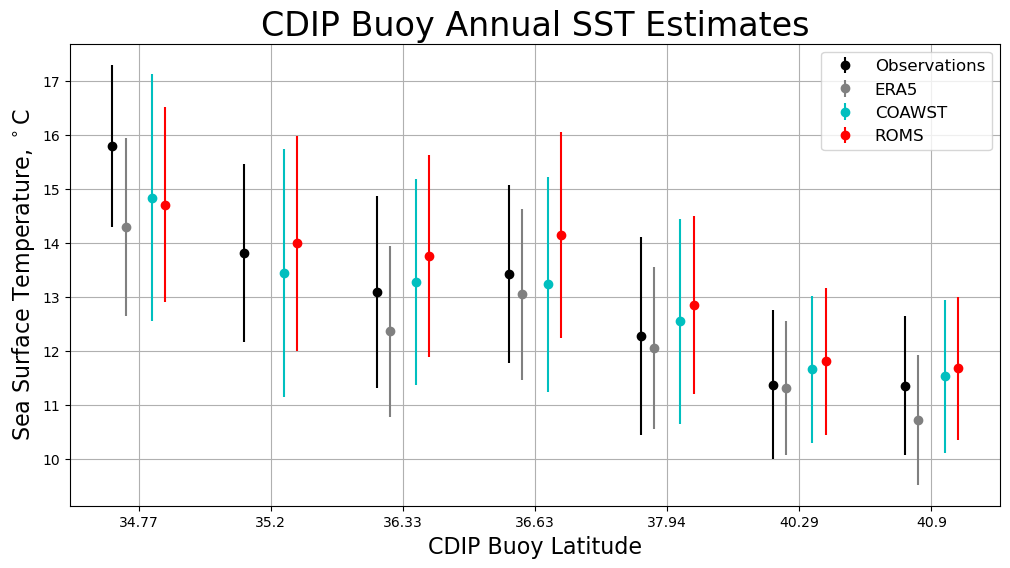

In [78]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

ptidx = 11
eralat = np.arange(len(ann_adf.lat[ptidx:]))
eralat = np.delete(eralat,1)

xobs = np.arange(len(ann_adf.lat[ptidx:]))-0.2
xera = eralat-0.1
x0plot = np.arange(len(ann_adf.lat[ptidx:]))+0.1
x1plot = np.arange(len(ann_adf.lat[ptidx:]))+0.2

ax.errorbar(xobs, ann_adf['Observations'][ptidx:], ann_sdf['Observations'][ptidx:], linestyle='None', color='k', marker='o',
            label='Observations')
ax.errorbar(xera, era5_mean['ERA5'], era5_std['ERA5'], linestyle='None', color='grey', marker='o',
            label='ERA5')
ax.errorbar(x0plot, ann_adf['Coupled COAWST'][ptidx:], ann_sdf['Coupled COAWST'][ptidx:], linestyle='None', marker='o', color='c',
            label='COAWST')
ax.errorbar(x1plot, ann_adf['Solo ROMS'][ptidx:], ann_sdf['Solo ROMS'][ptidx:], linestyle='None', marker='o', label='ROMS', color='r')

ax.set_xticks(np.arange(len(ann_adf.lat[ptidx:])), ann_adf['lat'][ptidx:])#, rotation='vertical')
ax.grid()
ax.legend(loc='upper right', fontsize=12)

ax.set_ylabel('Sea Surface Temperature, $^\circ$C', fontsize=16)
ax.set_xlabel('CDIP Buoy Latitude', fontsize=16)
ax.set_title('CDIP Buoy Annual SST Estimates', fontsize=24)

In [79]:
plotmons = calmons[7::] + calmons[1:7]
for i in range(len(plotmons)):
    if i<=5:
        plotmons[i] = plotmons[i]+'21'
    else:
        plotmons[i] = plotmons[i]+'22'

plotmons

['Jul21',
 'Aug21',
 'Sep21',
 'Oct21',
 'Nov21',
 'Dec21',
 'Jan22',
 'Feb22',
 'Mar22',
 'Apr22',
 'May22',
 'Jun22']

In [80]:
# coupled data frame of annual biases

cpl_df = pd.DataFrame(total_bias[0], plotmons, stn_name).T
cpl_df.insert(loc=0, column='lat', value=stn_lat)

print(cpl_df.shape)
cpl_df[cpl_df==9999] = np.nan
cpl_df_nonull = cpl_df.dropna(subset=['Jan22'], axis='index')


cpl_df_nonull = cpl_df_nonull.sort_values('lat', ascending=True)
cpl_df_nonull = cpl_df_nonull.drop(labels='lat', axis=1)

(30, 13)


In [81]:
tcoawst_bias = []
tcoawst_std = []
troms_bias = []
troms_std = []

for i in range(18):
    tcobs_grab = []
    trobs_grab = []

    troms_grab = []
    tcoawst_grab = []
    for j in range(12):
        tcobs_grab.append(total_obs[0][j][i])
        trobs_grab.append(total_obs[1][j][i])
        tcoawst_grab.append(total_mod[0][j][i])
        troms_grab.append(total_mod[1][j][i])

    tcobs_cat = xr.concat(tcobs_grab, dim="sst_time")
    trobs_cat = xr.concat(trobs_grab, dim="sst_time")
    tcoawst_cat = xr.concat(tcoawst_grab, dim="ocean_time")
    troms_cat = xr.concat(troms_grab, dim="ocean_time")
    
    cobs_tda = xr.DataArray(
        data=tcobs_cat.values,
        dims=["sst_time"],
        coords=dict(
            sst_time=tcoawst_cat.ocean_time.values,
        ),
        attrs=dict(
            description="SST.",
            units="degC",
        ),
    )

    robs_tda = xr.DataArray(
        data=trobs_cat.values,
        dims=["sst_time"],
        coords=dict(
            sst_time=troms_cat.ocean_time.values,
        ),
        attrs=dict(
            description="SST.",
            units="degC",
        ),
    )
    
    
    coawst_tda = xr.DataArray(
        data=tcoawst_cat.values,
        dims=["sst_time"],
        coords=dict(
            sst_time=tcoawst_cat.ocean_time.values,
        ),
        attrs=dict(
            description="SST.",
            units="degC",
        ),
    )

    roms_tda = xr.DataArray(
        data=troms_cat.values,
        dims=["sst_time"],
        coords=dict(
            sst_time=troms_cat.ocean_time.values,
        ),
        attrs=dict(
            description="SST.",
            units="degC",
        ),
    )

    coawst_bias = coawst_tda - cobs_tda
    roms_bias = roms_tda - robs_tda
    tcoawst_bias.append(coawst_bias.mean().values.item())
    tcoawst_std.append(coawst_bias.std().values.item())
    troms_bias.append(roms_bias.mean().values.item())
    troms_std.append(roms_bias.std().values.item())

In [83]:
def square_list(arr):
  return [x**2 for x in arr]

csqd = square_list(tcoawst_std)
rsqd = square_list(troms_std)

In [84]:
cpd_std = np.sqrt(np.mean(csqd))/ len(csqd)
sol_std = np.sqrt(np.mean(rsqd))/ len(rsqd)

In [85]:
sgrab_idx = [11,5,1,10,9,3,17]
for i in sgrab_idx:
    print(sub_sname[i])

HUMBOLDT BAY NORTH SPIT, CA
CAPE MENDOCINO, CA
POINT REYES, CA
CABRILLO POINT NEARSHORE, CA
POINT SUR, CA
DIABLO CANYON, CA
SANTA LUCIA ESCARPMENT, CA


In [86]:
cav_grab = []
sav_grab = []
csq_grab = []
ssq_grab = []

for i in sgrab_idx:
    cav_grab.append(tcoawst_bias[i])
    sav_grab.append(troms_bias[i])
    csq_grab.append(csqd[i])
    ssq_grab.append(rsqd[i])

cav_grab = np.asarray(cav_grab)
sav_grab = np.asarray(sav_grab)
csq_grab = np.asarray(csq_grab)
ssq_grab = np.asarray(ssq_grab)

In [87]:
# All stations north of Point Conception
ncpd_std = np.sqrt(np.mean(csq_grab))/ len(csq_grab)
nsol_std = np.sqrt(np.mean(ssq_grab))/ len(ssq_grab)

In [91]:
print('Northern COAWST CDIP Bias: %0.2f \u00B1 %0.2f' % (np.mean(cav_grab),ncpd_std))
print('Northern ROMS CDIP Bias: %0.2f \u00B1 %0.2f' % (np.mean(sav_grab),nsol_std))

Northern COAWST CDIP Bias: 0.15 ± 0.16
Northern ROMS CDIP Bias: 0.45 ± 0.14


In [95]:
# annual biases for solo ROMS runs

solo_df = pd.DataFrame(total_bias[1], plotmons, stn_name).T
solo_df.insert(loc=0, column='lat', value=stn_lat)

solo_df.shape
solo_df[solo_df==9999] = np.nan

solo_df_nonull = solo_df.dropna(subset=['Jan22'], axis='index')
solo_df_nonull = solo_df_nonull.sort_values('lat', ascending=True)
solo_df_nonull = solo_df_nonull.drop(labels='lat', axis=1)

### Combined Figure 2

In [107]:
# Grab lat/lon coordinates for stations in plots

lat_dfidx = []

solo_arr = np.array(solo_df.index)
for i in ssub_plot.index:
    lat_dfidx.append(np.argwhere(solo_arr==i).item())
    
s0lon = np.array(stn_lon)
s0lat = np.array(stn_lat)
s0lon = s0lon[lat_dfidx]
s0lat = s0lat[lat_dfidx]

In [116]:
ssub_latval = solo_df_nonull[7:]
csub_latval = cpl_df_nonull[7:]

jctr = 0
for j in ssub_latval.index:
    nu_idx = j[0:-4]+', %0.2f $^\circ$N' % s0lat[jctr]
    jctr+=1
    ssub_latval = ssub_latval.rename(index={j: nu_idx})
    csub_latval = csub_latval.rename(index={j: nu_idx})

In [ ]:
eralat = np.arange(len(ann_adf.lat[ptidx:]))
eralat = np.delete(eralat,1)

xobs = np.arange(len(ann_adf.lat[ptidx:]))-0.2
xera = eralat-0.1
x0plot = np.arange(len(ann_adf.lat[ptidx:]))+0.1
x1plot = np.arange(len(ann_adf.lat[ptidx:]))+0.2

ax.errorbar(xobs, ann_adf['Observations'][ptidx:], ann_sdf['Observations'][ptidx:], linestyle='None', color='k', marker='o',
            label='Observations')
ax.errorbar(xera, era5_mean['ERA5'], era5_std['ERA5'], linestyle='None', color='grey', marker='o',
            label='ERA5')

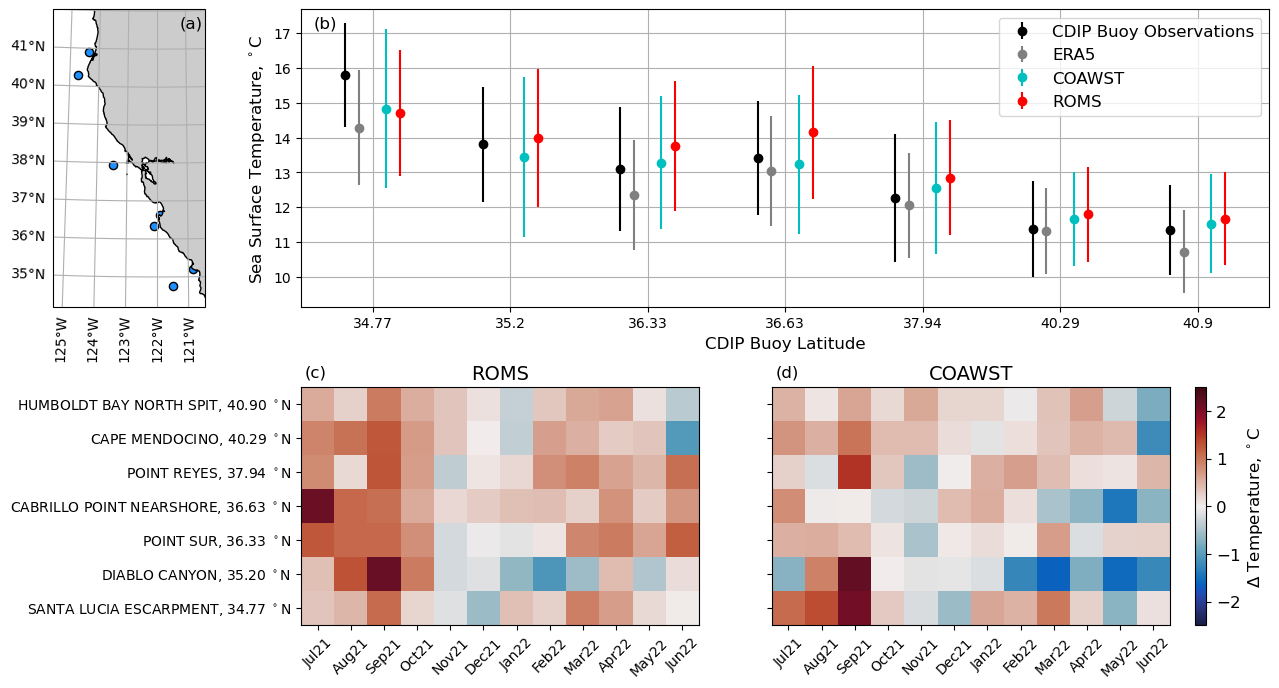

In [122]:
# fig = plt.figure(layout="constrained")
proj = ccrs.LambertConformal(central_longitude=-122, central_latitude=38)

lsidx = 5

fig = plt.figure(figsize=(16, 8))

gs = GridSpec(2, 3, width_ratios=[0.5, 1, 1.25], height_ratios=[1.25, 1], hspace=0.3)

#----------------------------------------------------------------------#
# Map of CDIP Buoy stations
ax = fig.add_subplot(gs[0, 0], projection=proj)

proj = ccrs.LambertConformal(central_longitude=-122, central_latitude=38)

coast_10m = cfeature.NaturalEarthFeature(
    "physical", "land", "10m", edgecolor="k", facecolor="0.8"
)
ax.add_feature(coast_10m)

pc = plt.scatter(x=s0lon[lsidx:], y=s0lat[lsidx:],
            color="dodgerblue",
            edgecolors='k',
            s=35,
            alpha=1.0,
            transform=ccrs.PlateCarree()) ## Important

ax.set_extent([-125.3, -120.5, 34.2, 42], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                    xlocs=np.arange(-130,-115, 1.0), ylocs=np.arange(31, 46, 1.0))
 
# manipulate `gridliner` object to change locations of labels
gl.top_labels = False
gl.right_labels = False

plt.rcParams.update({'font.size': 10})

#----------------------------------------------------------------------#
# Annual temperature comparisons for all stations
ax = fig.add_subplot(gs[0, 1::])

pidx = 11

eralat = np.arange(len(ann_adf.lat[ptidx:]))
eralat = np.delete(eralat,1)

xobs = np.arange(len(ann_adf.lat[ptidx:]))-0.2
xera = eralat-0.1
x0plot = np.arange(len(ann_adf.lat[ptidx:]))+0.1
x1plot = np.arange(len(ann_adf.lat[ptidx:]))+0.2

ax.errorbar(xobs, ann_adf['Observations'][ptidx:], ann_sdf['Observations'][ptidx:], linestyle='None', color='k', marker='o',
            label='CDIP Buoy Observations')
ax.errorbar(xera, era5_mean['ERA5'], era5_std['ERA5'], linestyle='None', color='grey', marker='o',
            label='ERA5')


ax.errorbar(x0plot, ann_adf['Coupled COAWST'][pidx:], ann_sdf['Coupled COAWST'][pidx:], linestyle='None', marker='o', color='c',
            label='COAWST')
ax.errorbar(x1plot, ann_adf['Solo ROMS'][pidx:], ann_sdf['Solo ROMS'][pidx:], linestyle='None', marker='o', label='ROMS', color='r')

ax.set_xticks(np.arange(len(ann_adf.lat[pidx:])), ann_adf['lat'][pidx:])#, rotation='vertical')
ax.grid()
ax.legend(loc='upper right', fontsize=12)

ax.set_ylabel('Sea Surface Temperature, $^\circ$C', fontsize=12)
ax.set_xlabel('CDIP Buoy Latitude', fontsize=12)
ax.text(-0.43, 17.15, '(b)', fontsize=12)
ax.text(-1.4, 17.15, '(a)', fontsize=12)

#----------------------------------------------------------------------#
# Hövmoller Plot - ROMS
ax = fig.add_subplot(gs[1, 1])

heatmap = ax.pcolormesh(ssub_latval[lsidx:], cmap=cmo.balance, alpha=1, vmin=-2.5, vmax=2.5)

ax.set_yticks(np.arange(ssub_latval[lsidx:].shape[0]) + 0.5, minor=False)
ax.set_xticks(np.arange(ssub_latval[1:].shape[1]) + 0.5, minor=False)
ax.set_xticklabels(ssub_latval[lsidx:].columns, minor=False, rotation=45)
ax.set_yticklabels(ssub_latval[lsidx:].index, minor=False)
ax.set_title('ROMS', fontsize=14)
ax.text(0.1, 7.3, '(c)', fontsize=12)

#----------------------------------------------------------------------#
# Hövmoller Plot - COAWST
ax = fig.add_subplot(gs[1, 2])

heatmap = ax.pcolormesh(csub_latval[lsidx:], cmap=cmo.balance, alpha=1, vmin=-2.5, vmax=2.5)
cbar = fig.colorbar(heatmap)
cbar.set_label('$\Delta$ Temperature, $^\circ$C', fontsize=12)
cbar.ax.tick_params(labelsize=12)

ax.set_yticks(np.arange(csub_latval[lsidx:].shape[0]) + 0.5, minor=False)
ax.set_xticks(np.arange(csub_latval[lsidx:].shape[1]) + 0.5, minor=False)
ax.set_xticklabels(csub_latval[lsidx:].columns, minor=False, rotation=45)
ax.set_yticklabels('', minor=False)
ax.set_title('COAWST', fontsize=14)
ax.text(0.1, 7.3, '(d)', fontsize=12)

fig.savefig('Figure_2.png', format='png', dpi=300)


In [123]:
# Observed station SST averages
ann_adf['Observations'][ptidx:]

SANTA LUCIA ESCARPMENT, CA      15.798885
DIABLO CANYON, CA               13.808931
POINT SUR, CA                   13.087193
CABRILLO POINT NEARSHORE, CA    13.419455
POINT REYES, CA                 12.272407
CAPE MENDOCINO, CA              11.372152
HUMBOLDT BAY NORTH SPIT, CA     11.352044
Name: Observations, dtype: float64

In [124]:
# Observed station SST standard deviations
ann_sdf['Observations'][ptidx:]

SANTA LUCIA ESCARPMENT, CA      1.498736
DIABLO CANYON, CA               1.650606
POINT SUR, CA                   1.780197
CABRILLO POINT NEARSHORE, CA    1.646327
POINT REYES, CA                 1.837635
CAPE MENDOCINO, CA              1.381338
HUMBOLDT BAY NORTH SPIT, CA     1.285592
Name: Observations, dtype: float64